<img src="./images/eu_banner.png" alt="EU Banner" width="100%"/>

# **LISFLOOD Use Case - 0) Catchment Overview**
---

This use case intends to introduce the basic mechanics of the hydrological model [LISFLOOD](https://github.com/ec-jrc/lisflood-code/).
<br>
In this exercise, the objective is to read and visualize some of the static and dynamic maps as well as meteorological forcings required in LISFLOOD. <br>
As we can't discuss all input files in detail, a full list with details can be found [here](https://ec-jrc.github.io/lisflood-code/4_annex_input-files/).

## **0a) Input Data**

LISFLOOD contains dozens of input files, more precisely maps that are either static (no time dimension) or dynamic (with time dimension). <br>
Besides, LISFLOODs meteorological inputs will be counted and explored here as a standalone category of the inputs.<br>
In our example model of the Aisén River, all input maps (meteo, static, dynamic) are found in the **`maps`** and **`meteo`** folder.

Meteorological input variables refer to:
* Daily precipitation rates, indicated as **`pr`** or **`tp`** (mm/d)
* Average daily temperature, indicated as **`Tavg`** or **`ta`** (°C)
* Daily potential evaporation rate from free water surface, indicated as **`e`** or **`E0`** (mm/d)
* Daily potential evaporation rate from bare soil, indicated as **`es`** or **`ES0`** (mm/d)
* Daily potential evaporation rate from reference crop, indicated as **`et`** or **`ET0`** (mm/d)

Note, users are thus obliged to provide potential evapotranspiration maps to run the model. <br> 
The preperation of the evapotranspiration maps can be done for example using [LISVAP](https://github.com/ec-jrc/lisflood-lisvap). <br>
As LISVAP uses Penman-Monteith to calculate potential evapotranspiration, additional inputs are required. <br>
However, LISVAP is discussed in a separate exercise (see XX). 
***

### **Meteorological Check**
We will now have a look at the temperature, precipitation and evapotranspiration regime of our studz area via Python. <br>
This refers to an important step every modeller should undertake before starting the actual modeling work.<br>
A meteorological check helps the user to get an idea on what to expect hydrologically in terms of general dryness and wetness (aridity), temporal (seasonal) behavior,<br>
but also for plausibility reasons whether annual averages & units are reasonable.

In our example we have one file per variable and year and a prefix *"glofas_"*, e.g. for temperature **`glofas_ta_YYYY`**, where YYYY indicates the specific year.

In [29]:
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# define paths
path_model = Path('../meteo/meteo_clipped')

# read temp
VAR = "ta"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
tavg = xr.open_mfdataset(files, combine="by_coords")

# read precip
VAR = "tp"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
precip = xr.open_mfdataset(files, combine="by_coords")

# read E0 (pot. open water evaporation)
VAR = "e0"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
e0 = xr.open_mfdataset(files, combine="by_coords")

# read ES0 (pot. plant transpiration)
VAR = "eS0"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
es0 = xr.open_mfdataset(files, combine="by_coords")

# read ET0 (pot. plant transpiration)
VAR = "eT0"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
et0 = xr.open_mfdataset(files, combine="by_coords")

Now that all meteorological variables are properly read, we will investigate the basin characteristics further.<br>
However, first we will sum up the individual potential evapotranspiration files to get a total potential evapotranspiration value.

In [30]:
# sum potential evapotranspiration
pet = e0['e0'] + es0['eS0'] + et0['eT0']
# make a ds for consistency
pet = pet.to_dataset(name='pet')


Since timestamps refer to 00:00 (midnight) at the end of the daily time step, for instance 2020-01-01 00:00 represents the end of 31 December 2019.
For aggregation purposes we will shift the timestamp of the variables by 1 day.

In [47]:
pet['time'] = pet['time'] - pd.Timedelta(days=1)
tavg['time'] = tavg['time'] - pd.Timedelta(days=1)
precip['time'] = precip['time'] - pd.Timedelta(days=1)

Now let us have a look at the meteorological variables and what it tells us about the study area.
For this, we first create monthly, annual and seasonal arrays.<br>
First we will check annual average maps of the variables

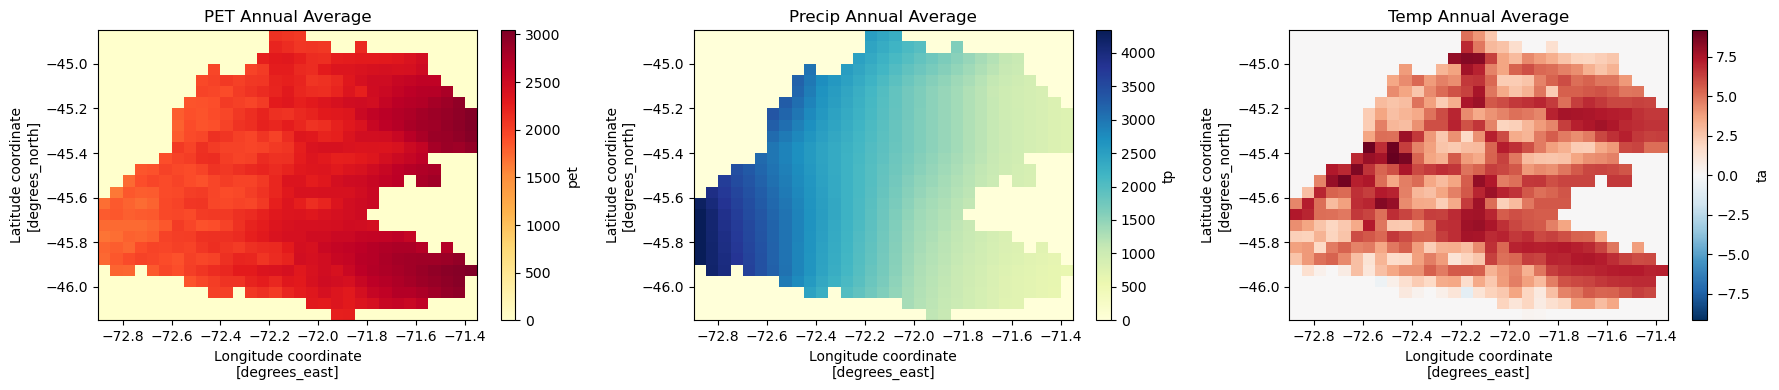

In [49]:
# Annual
pet_a = pet.resample(time='Y').sum()
precip_a = precip.resample(time='Y').sum()
tavg_a = tavg.resample(time='Y').mean()

# Annual Averages
pet_aa = pet_a.mean(dim="time")
precip_aa = precip_a.mean(dim="time")
tavg_aa = tavg_a.mean(dim="time")


fig, axes = plt.subplots(1, 3, figsize=(18, 4))
pet_aa.pet.plot(ax=axes[0], cmap='YlOrRd')
axes[0].set_title('PET Annual Average')

precip_aa.tp.plot(ax=axes[1], cmap='YlGnBu')
axes[1].set_title('Precip Annual Average')

tavg_aa.ta.plot(ax=axes[2], cmap='RdBu_r')
axes[2].set_title('Temp Annual Average')
fig.tight_layout()


In the annual average plots can see already some precipitation and potential evapotranspiration gradients from West to East.

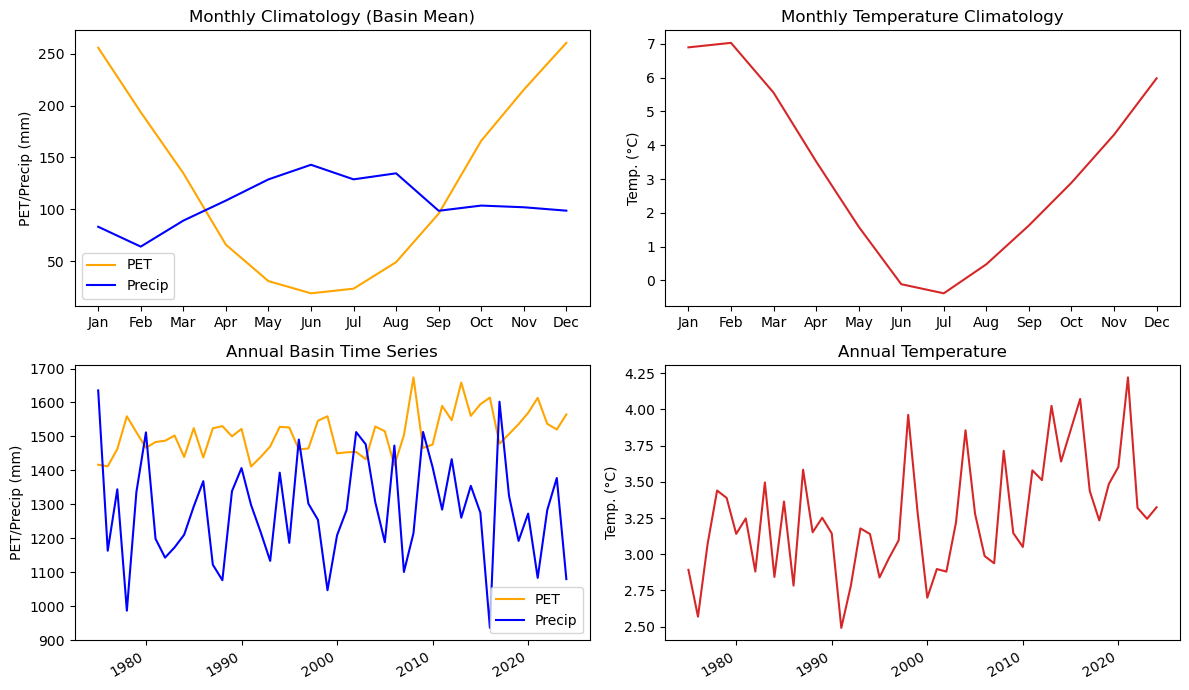

In [66]:

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# create the basin files
pet_basin    = pet.mean(dim=["lat", "lon"], skipna=True)
precip_basin = precip.mean(dim=["lat", "lon"], skipna=True)
tavg_basin   = tavg.mean(dim=["lat", "lon"], skipna=True)

pet_m    = pet_basin.resample(time="MS").sum()
precip_m = precip_basin.resample(time="MS").sum()
tavg_m   = tavg_basin.resample(time="MS").mean()

pet_a    = pet_basin.resample(time="YS").sum()
precip_a = precip_basin.resample(time="YS").sum()
tavg_a   = tavg_basin.resample(time="YS").mean()

pet_s    = pet_m.groupby("time.month").mean()
precip_s = precip_m.groupby("time.month").mean()
tavg_s   = tavg_m.groupby("time.month").mean()


fig, axes = plt.subplots(2, 2, figsize=(12, 7))
# --- Monthly climatology ---
pet_s.pet.plot(ax=axes[0,0], label="PET",color="orange")
precip_s.tp.plot(ax=axes[0,0], label="Precip",color="b")
axes[0,0].set_title("Monthly Climatology (Basin Mean)")
axes[0,0].set_ylabel("PET/Precip (mm)")
axes[0,0].set_xlabel("Month")
axes[0,0].legend()
axes[0,0].set_xticks(range(1,13))
axes[0,0].set_xticklabels(months)
axes[0,0].set_xlabel("")

tavg_s.ta.plot(ax=axes[0,1], color="tab:red")
axes[0,1].set_title("Monthly Temperature Climatology")
axes[0,1].set_ylabel("Temp. (°C)")
axes[0,1].set_xlabel("Month")
axes[0,1].set_xticks(range(1,13))
axes[0,1].set_xticklabels(months)
axes[0,1].set_xlabel("")

# --- Annual time series ---
pet_a.pet.plot(ax=axes[1,0], label="PET",color="orange")
precip_a.tp.plot(ax=axes[1,0], label="Precip",color="b")
axes[1,0].set_title("Annual Basin Time Series")
axes[1,0].set_ylabel("PET/Precip (mm)")
axes[1,0].set_xlabel("")
axes[1,0].legend()

tavg_a.ta.plot(ax=axes[1,1], color="tab:red")
axes[1,1].set_title("Annual Temperature")
axes[1,1].set_ylabel("Temp. (°C)")
axes[1,1].set_xlabel("")

fig.tight_layout()

In [80]:
# check aridity index 
ai = precip_a.tp.mean(dim="time").values/pet_a.pet.mean(dim="time").values
print(f"Aridity Index for the whole time series is {ai:.2f}")

Aridity Index for the whole time series is 0.85


We immediately notice the notably smaller variability of PET compared to precipitation, as well as the contrasting seasonal patterns of both (rainy season in Winter of Southern Hemisphere when temperatures are low).<br>
Besides, we can see that there is a slight trend in the annual temperature time series from (approx.) the 2000s onward, which gives you already some hydrological implications for your modeling.<br>
The seasonality in precipitation, peaking in May to August, suggests that this will be our high-flow period. <br>
Lastly, the aridity index, calculated as the quotient of long-term precipitation and long-term PET indicates a humid climate type of the basin, and therefore not water-limited. 

---

### **Static Maps Check**

Next, we will have a look at some static maps, variables that do not change over time and serve as important inputs to the model.
We will have a look at:
* Some soil properties
* Land use information



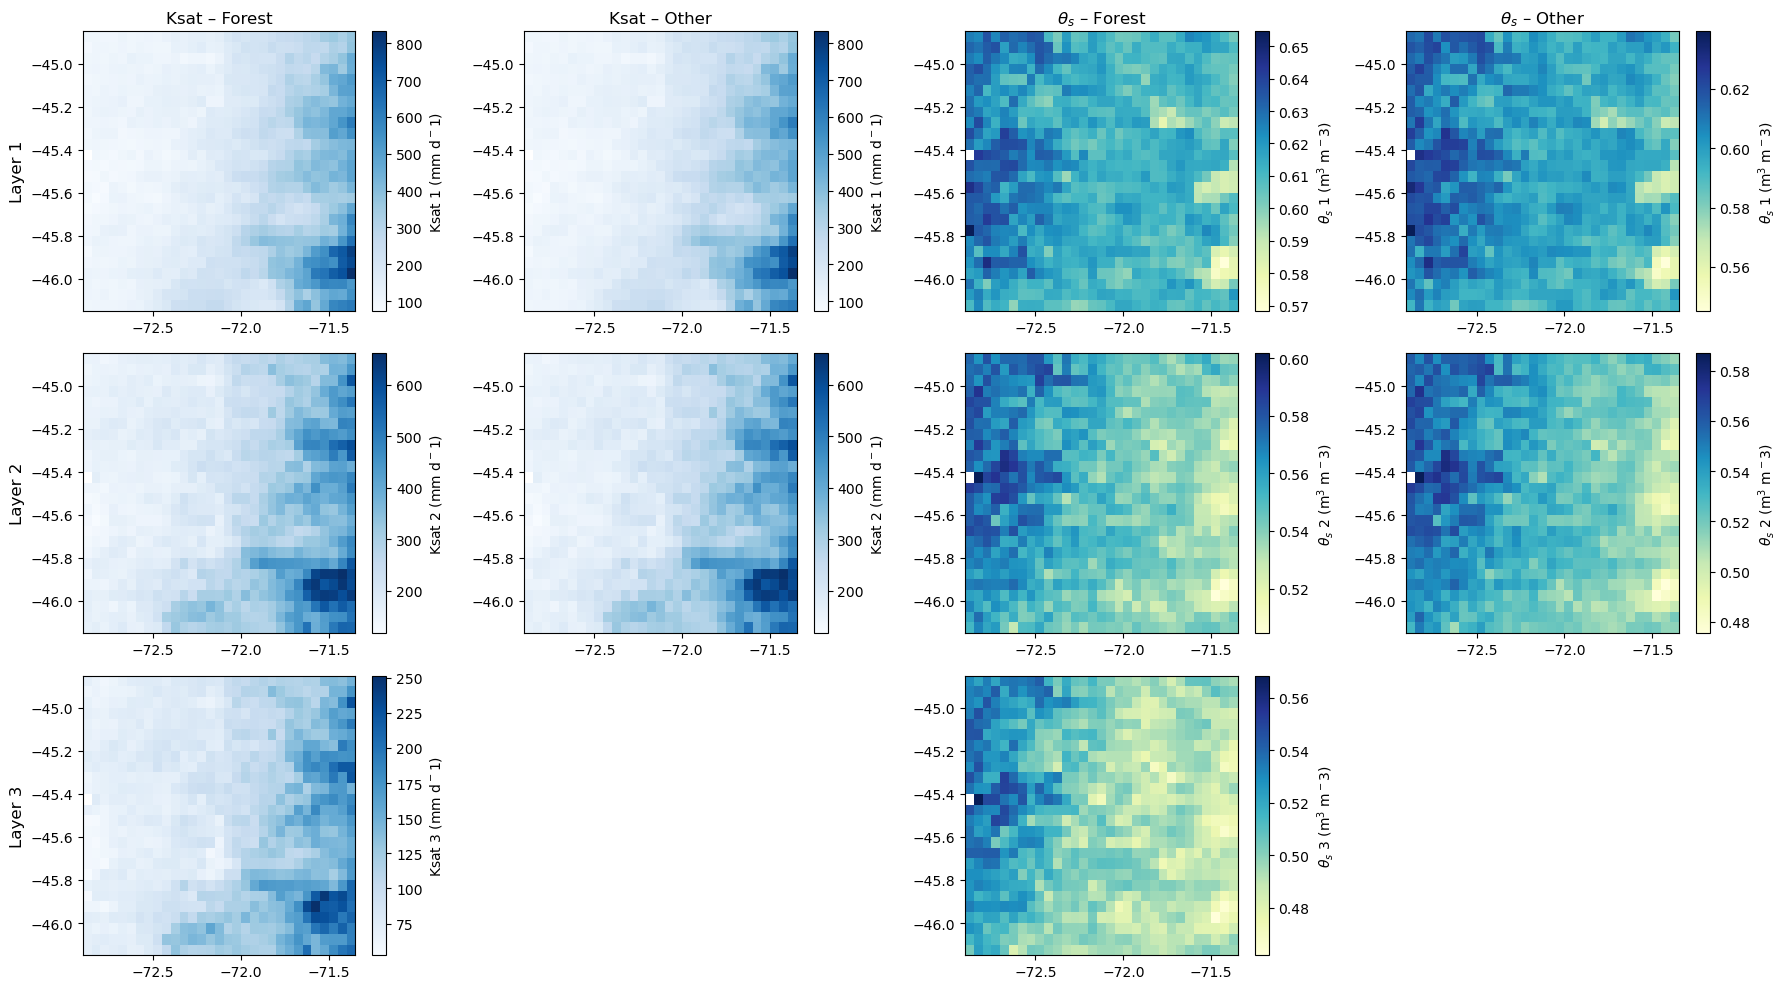

In [110]:
# load maps:
#     "ksat" is the saturated hydraulic conductivity of the soil in (mm/d)
#     "thetas" is the volumetric water content of the saturated soil in (m3/m3)
#     "1", "2", "3" refer to the soil layers (note that for layer 3 no distinction between forest & other land uses is done anymore)
#     "f" refers to the fraction of soil covered by forests (note that for layer 3 no distinction between forest & other land uses is done anymore)
#     "a" refers to the fraction of other land use classes than forest (note that for layer 3 no distinction between forest & other land uses is done anymore)
# define paths
path_model = Path('../maps')
# define variable names
variables = ['ksat1_f', 'ksat1_o' 'ksat2_f', 'ksat2_o', 'ksat3', 'thetas1_f', 'thetas1_o', 'thetas2_f', 'thetas2_o', 'thetas3']
variables = [
    'ksat1_f', 'ksat1_o',
    'ksat2_f', 'ksat2_o',
    'ksat3',
    'thetas1_f', 'thetas1_o',
    'thetas2_f', 'thetas2_o',
    'thetas3'
]
suffix = "Global2_03min"
# read variables
soils = {}
for var in variables:
    ds = xr.open_dataset(path_model / f'{var}_{suffix}.nc')
    ds.close()
    soils[var] = ds['Band1']

# plot maps
fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(18, 10))

layers = [1, 2, 3]

for i, layer in enumerate(layers):

    # --- KSAT ---
    if layer < 3:
        soils[f'ksat{layer}_f'].plot(
            ax=axes[i, 0], cmap='Blues',
            cbar_kwargs={'label': rf'Ksat {layer} (mm d$^{-1}$)'}
        )
        soils[f'ksat{layer}_o'].plot(
            ax=axes[i, 1], cmap='Blues',
            cbar_kwargs={'label': rf'Ksat {layer} (mm d$^{-1}$)'}
        )
    else:
        soils['ksat3'].plot(
            ax=axes[i, 0], cmap='Blues',
            cbar_kwargs={'label': rf'Ksat {layer} (mm d$^{-1}$)'}
        )
        axes[i, 1].axis('off')
        # soils['ksat3'].plot(
        #     ax=axes[i, 1], cmap='Blues',
        #     cbar_kwargs={'label': rf'Ksat {layer} (mm d$^{-1}$)'}
        # )

    # --- THETAS ---
    if layer < 3:
        soils[f'thetas{layer}_f'].plot(
            ax=axes[i, 2], cmap='YlGnBu',
            cbar_kwargs={'label': rf'$\theta_s$ {layer} (m$^3$ m$^{-3}$)'}
        )
        soils[f'thetas{layer}_o'].plot(
            ax=axes[i, 3], cmap='YlGnBu',
            cbar_kwargs={'label': rf'$\theta_s$ {layer} (m$^3$ m$^{-3}$)'}
        )
    else:
        soils['thetas3'].plot(
            ax=axes[i, 2], cmap='YlGnBu',
            cbar_kwargs={'label': rf'$\theta_s$ {layer} (m$^3$ m$^{-3}$)'}
        )
        axes[i, 3].axis('off')
        # soils['thetas3'].plot(
        #     ax=axes[i, 3], cmap='YlGnBu',
        #     cbar_kwargs={'label': rf'$\theta_s$ {layer} (m$^3$ m$^{-3}$)'}
        # )

    # Row labels
    axes[i, 0].set_ylabel('')
    axes[i, 1].set_ylabel('')
    axes[i, 2].set_ylabel('')
    axes[i, 3].set_ylabel('')
    axes[i, 0].set_ylabel(f'Layer {layer}', fontsize=12)

# Clean axes
for ax in axes.flat:
#     ax.axis('off')
    ax.set_title("")
    ax.set_xlabel("")


# Column titles
col_titles = [
    'Ksat – Forest', 'Ksat – Other',
    r'$\theta_s$ – Forest', r'$\theta_s$ – Other'
]

for j, title in enumerate(col_titles):
    axes[0, j].set_title(title, fontsize=12)

fig.tight_layout()

We will now have a look at the saturated hydraulic conductivity and investigate the differences between the layers in a more differentiable way.
For this let us plot five boxplots.

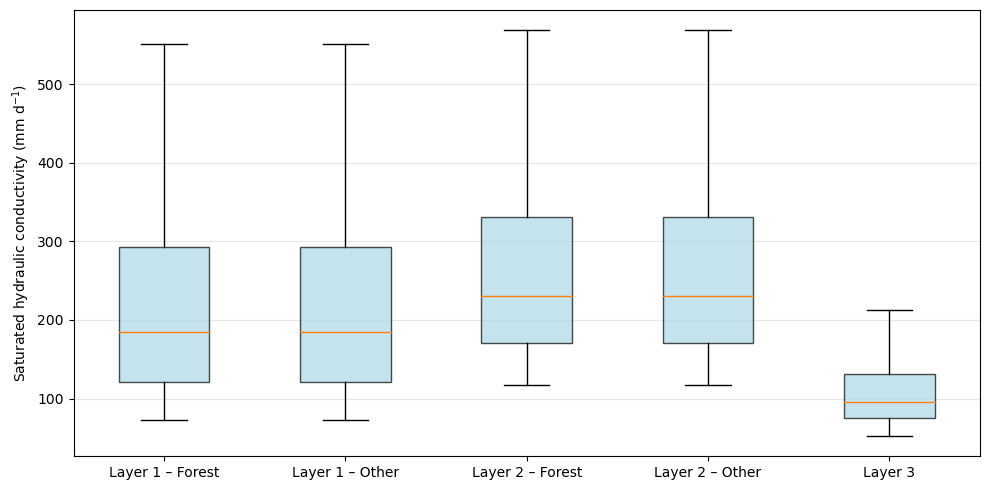

In [121]:
ksat_vars = [
    'ksat1_f', 'ksat1_o',
    'ksat2_f', 'ksat2_o',
    'ksat3'
]

labels = [
    'Layer 1 – Forest',
    'Layer 1 – Other',
    'Layer 2 – Forest',
    'Layer 2 – Other',
    'Layer 3'
]

data = []

for var in ksat_vars:
    da = soils[var]
    
    # mask invalid values
    da = da.where(da > 0)
    # flatten lat/lon → 1D
    values = da.values.flatten()
    
    # drop NaNs
    values = values[~np.isnan(values)]
    
    data.append(values)

# plot
fig, ax = plt.subplots(figsize=(10, 5))

bp = ax.boxplot(
    data,
    labels=labels,
    showfliers=False,      # cleaner for skewed Ksat
    patch_artist=True
)

# Styling
for box in bp['boxes']:
    box.set(facecolor='lightblue', alpha=0.7)

ax.set_ylabel(r'Saturated hydraulic conductivity (mm d$^{-1}$)')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

You probably notice that the **forest** and **other** land use classes hydraulic conductivity values look suspiciously similar.<br>
In our example we did not distinguish the soil properties for a specific pixel further based on land use.

---

### **Dynamic Maps Check**

Let us load and identify the land use maps, which count as static maps in LISFLOOD as they provide fractions of land use classes per pixel.<br>
The land use classes considered in LISFLOOD are:
* Forest
* Other (e.g., non-forested natural such as grassland, agricultural, etc.)
* Sealed
* Water
* Rice

Fractions can be provided as time series to model and consider land use changes or (as in our example) users ocan use static land-use maps without a time dimension.<br>
We will map the different land use fractions for the basin scale.

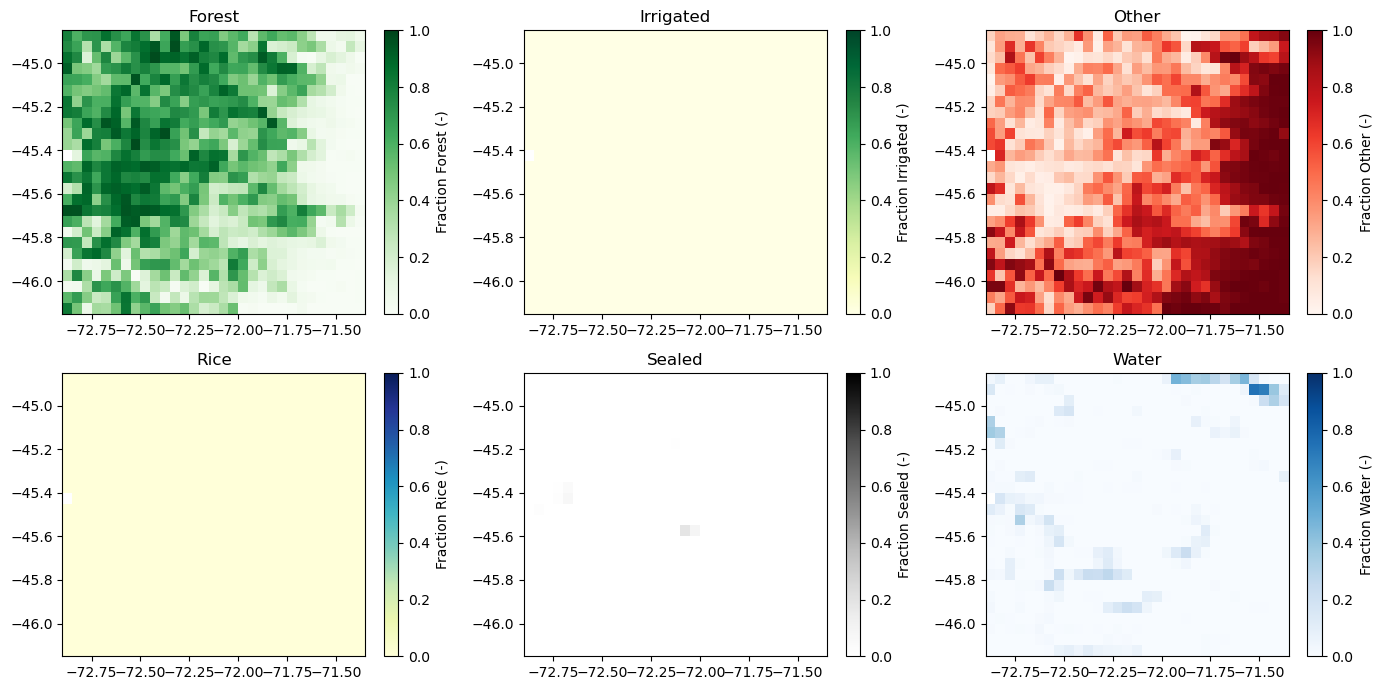

In [159]:
# define paths
path_model = Path('../maps')
# define variables
variables =  ['forest', 'irrigated', 'other', 'rice', 'sealed', 'water']
land_use = {}
for var in variables:
    if var in(["other","irrigated"]):
        suffix = "Global2_03min"
    else:
        suffix = "Global_03min"

    da = xr.open_dataset(path_model / f'frac{var}_{suffix}.nc')
    da.close()
    land_use[var] = da

# define colormaps 
cmaps = {
    'forest':     'Greens',    # forest vegetation
    'irrigated':  'YlGn',      # agriculture / crops 
    'rice':       'YlGnBu',    # wet agriculture (green → blue)
    'water':      'Blues',     # water
    'sealed':     'Greys',     # urban / impervious
    'other':      'Reds',   # mixed / grass / range etc.
}

# plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))

axes = axes.flatten()

for ax, (name, ds) in zip(axes, land_use.items()):
    da = ds.Band1  # Dataset → DataArray

    da.plot(ax=ax, cmap = cmaps[name],vmin=0,vmax=1, cbar_kwargs={"label": f"Fraction {name.capitalize()} (-)"})

    ax.set_title(name.capitalize())
    ax.set_xlabel("")
    ax.set_ylabel("")
fig.tight_layout()


If you want to check whether your fractions were properly set, you can stack the fractions and sum them to see whether everything is 1.<br>
The outlet location btw. is a NaN value and thus can be ignored. <br>
It should look similar to below:

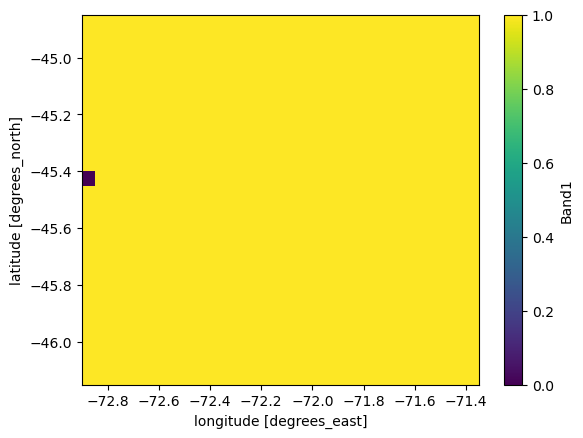

In [ ]:
da_stack = xr.concat([ds.Band1 for ds in land_use.values()], dim="class")
da_stack.sum(dim="class").plot()

And what are our dominant land use clases in the study area? <br>
Let us have a look and from our maps we expect the forest and other class to be dominant!

In [182]:
print(f"The catchment contains a fraction of {land_use['forest'].Band1.mean().item():.3f} forest")
print(f"The catchment contains a fraction of {land_use['other'].Band1.mean().item():.3f} other")
print(f"The catchment contains a fraction of {land_use['water'].Band1.mean().item():.3f} water")
print(f"The catchment contains a fraction of {land_use['sealed'].Band1.mean().item():.3f} sealed areas")


The catchment contains a fraction of 0.452 forest
The catchment contains a fraction of 0.526 other
The catchment contains a fraction of 0.021 water
The catchment contains a fraction of 0.001 sealed areas


## TESTS (TO BE DELETED)

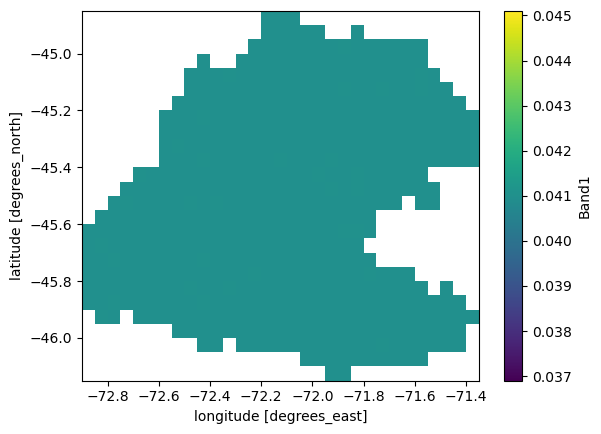

In [84]:
pathtest = Path("/home/schafti/Documents/01_Hydrology/01_Lisflood/00_SourceCode/01_Playground/01_Test_Usecase/create_submodel_7859/7859_testing/cutmaps_check/cutmaps_test_stefania2/thetar2_f_Global2_03min.nc")
test3 = xr.open_dataset(pathtest)
test3.Band1.plot()

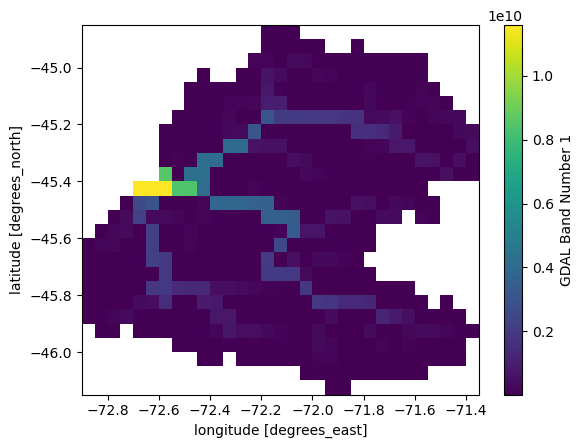

In [ ]:
pathtest = Path("/home/schafti/Documents/01_Hydrology/01_Lisflood/00_SourceCode/01_Playground/01_Test_Usecase/create_submodel_7859/7859_testing/cutmaps_check/cutmaps_test_stefania2/upArea_repaired.nc")
test2 = xr.open_dataset(pathtest)
test2.Band1.plot()

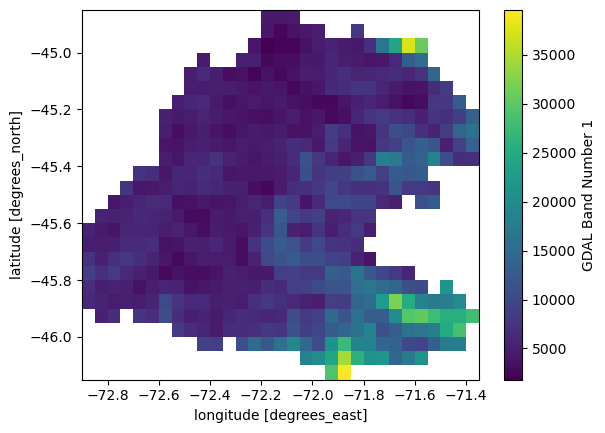

In [82]:
pathtest = Path("/home/schafti/Documents/01_Hydrology/01_Lisflood/00_SourceCode/01_Playground/01_Test_Usecase/create_submodel_7859/7859_testing/cutmaps_check/cutmaps_test_stefania/soildepth3_o_Global_03min_clipped.nc")
test = xr.open_dataset(pathtest)
test.Band1.plot()